# $$ \text{Data Collection} $$

## Import Libraries & Utils

In [1]:
from common.openalex_collect import fetch_openalex
from common.utils import write_partitioned_by_year
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8"); sns.set_theme(style="whitegrid")

/home/hoangvu/BigData-Keyword-Extraction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Configs

In [2]:
config_url = "configs/collect_config.yaml"

with open(config_url, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

config

{'year_from': 2010,
 'year_to': 2025,
 'max_per_year': 500,
 'per_page': 200,
 'sleep_sec': 3.0,
 'paths': {'raw': '../services/backend/data/raw'}}

## Collect

In [3]:
df = fetch_openalex(config["year_from"], config["year_to"], config["per_page"], config["max_per_year"], config["sleep_sec"])

## EDA

In [4]:
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (8000, 9)
Columns: Index(['id', 'title', 'abstract', 'year', 'authors', 'keywords_gold',
       'doc_text', 'n_tokens', 'uid'],
      dtype='object')


In [5]:
display(df.head())

,id,title,abstract,year,authors,keywords_gold,doc_text,n_tokens,uid
0,W2092157292,A consistent and accurate<i>ab initio</i>param...,The method of dispersion correction as an add-...,2010,"[Stefan Grimme, Jens Antony, Stephan Ehrlich, ...","[Density functional theory, Dispersion (optics...",A consistent and accurate<i>ab initio</i>param...,315,8f85584b604658070ab0332934846d039a69b957
1,W2072970694,QIIME allows analysis of high-throughput commu...,,2010,"[J. Gregory Caporaso, Justin Kuczynski, Jesse ...","[Throughput, DNA sequencing, Computational bio...",QIIME allows analysis of high-throughput commu...,8,c04004f9c3899c5c300fa2558c64efdc8a501824
2,W2289205268,Como Elaborar Projetos de Pesquisa,Elaborar um projeto de pesquisa para conferir ...,2010,[Antônio Carlos Gil],"[Humanities, Philosophy, Political science, Co...",Como Elaborar Projetos de Pesquisa\n\nElaborar...,139,30e01f062dafb04207c4bea498b99f61d9d127e6
3,W2119180969,The Genome Analysis Toolkit: A MapReduce frame...,"Next-generation DNA sequencing (NGS) projects,...",2010,"[Aaron McKenna, Matthew G. Hanna, Eric Banks, ...","[Computer science, Genome, Correctness, 1000 G...",The Genome Analysis Toolkit: A MapReduce frame...,248,c7357b23516fd0225161f4e5cd5032c0e9e6939a
4,W2124026197,Features and development of <i>Coot</i>,Coot is a molecular-graphics application for m...,2010,"[Paul Emsley, Bernhard Lohkamp, W. G. Scott, K...","[Computer science, Scripting language, Softwar...",Features and development of <i>Coot</i>\n\nCoo...,163,e09fa45036d9fa35b3309ff6867e05637a96d9a0


In [6]:
print("Dtypes:\n", df.dtypes)
print("Missing values per columns:\n", df.isna().sum())

Dtypes:
 id               object
title            object
abstract         object
year              int64
authors          object
keywords_gold    object
doc_text         object
n_tokens          int64
uid              object
dtype: object
Missing values per columns:
 id               0
title            0
abstract         0
year             0
authors          0
keywords_gold    0
doc_text         0
n_tokens         0
uid              0
dtype: int64


In [7]:
df["doc_text_len"] = df["doc_text"].fillna("").astype(str).str.len()

display(df[["n_tokens", "doc_text_len"]].describe())

,n_tokens,doc_text_len
count,8000.00000,8000.000000
mean,116.21125,823.014875
std,165.32781,1138.649292
min,1.00000,3.000000
25%,11.00000,81.000000
50%,87.00000,615.000000
75%,186.00000,1311.000000
max,4199.00000,29959.000000


Saved EDA summary plot to ../services/backend/data/raw/eda_summary.png


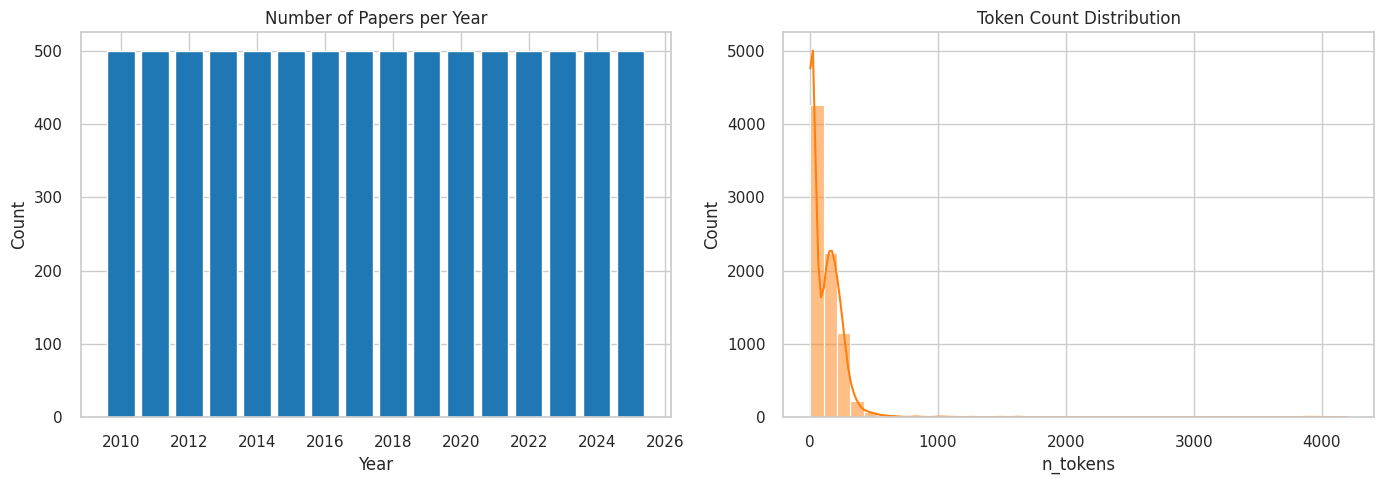

In [8]:
summary_dir = Path(config["paths"]["raw"])
summary_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
year_counts = df.groupby("year").size().sort_index()
axes[0].bar(year_counts.index, year_counts.values, color="#1f77b4")
axes[0].set_title("Number of Papers per Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")

sns.histplot(df["n_tokens"], bins=40, ax=axes[1], kde=True, color="#ff7f0e")
axes[1].set_title("Token Count Distribution")
axes[1].set_xlabel("n_tokens")

plt.tight_layout()
fig_path = summary_dir / "eda_summary.png"
plt.savefig(fig_path, dpi=120)
print("Saved EDA summary plot to", fig_path)

## Store

In [9]:
write_partitioned_by_year(df, config["paths"]["raw"])

---